## SUPERVISED LEARNING MODELS

# Import the Librairies

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score, auc, RocCurveDisplay
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Import the data

In [3]:
data = pd.read_csv(r'C:\Users\Ingrid\Desktop\DAFT Nov 21\Projects\Final project\churn_encoded.csv')
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Target
0,724,0,0,33,3,77299.370000,1,0,0,174433.518000,0
1,801,0,0,32,4,75170.540000,1,1,1,37898.500000,0
2,616,0,0,36,5,0.000000,1,0,0,139714.081429,0
3,570,1,0,36,5,142111.666667,2,1,1,110629.520000,0
4,632,0,0,36,6,0.000000,1,0,0,74353.966154,0


In [4]:
data.shape

(4072, 11)

In [5]:
data.dtypes

CreditScore          int64
Geography            int64
Gender               int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Target               int64
dtype: object

#### We define X and y:

In [6]:
X= data.drop('Target', axis=1)
y=data['Target']

# Features Selection

#### **First method: Select from model**

In [7]:
SFM = SelectFromModel(estimator=RandomForestClassifier())
s=SFM.fit(X, y)

In [8]:
n_features = s.transform(X).shape[1]

print(f'Number of features: {n_features}')
feature_idx = s.get_support()
feature_name = X.columns[feature_idx]
print(f'Features selected:\n{feature_name}') 

Number of features: 4
Features selected:
Index(['CreditScore', 'Age', 'Balance', 'EstimatedSalary'], dtype='object')


#### **Second model: RFE**

In [9]:
rfe_selector = RFE(estimator=RandomForestClassifier())
m=rfe_selector.fit(X, y)
X.columns[m.get_support()]

print("Num Features: %s" % (m.n_features_))
print("Selected Features: %s" % (m.support_))
print("Feature Ranking: %s" % (m.ranking_))

Num Features: 5
Selected Features: [ True False False  True  True  True False False False  True]
Feature Ranking: [1 4 5 1 1 1 2 3 6 1]


#### **Third model: RFECV**

In [10]:
rfecv = RFECV(
    estimator=RandomForestClassifier(),
    min_features_to_select=2,
    step=1,
    n_jobs=-1,
    verbose=1,
    scoring="r2",
    cv=5,
)

m= rfecv.fit(X, y)

In [11]:
X.columns[rfecv.support_]

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

Comment: RFE and RFECV suggest to take only 4 or 5 features but RFECV is more accurate so we are going to use all the features.

# Hyperparameters tuning

#### We are going to use 3 supervised classification models:
- SVC
- ExtraTreesClassifier 
- RandomForestClassifier

In [12]:
# We test 20% of our dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# This function returns 4 variables
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(3257, 10)
(3257,)
(815, 10)
(815,)


Comment: We have 3257 observations in the train data and 815 observations in the test data.

In [13]:
# We scale our training data
X_stand = StandardScaler().fit_transform(X)

Here, we don't use the GridSearch method because it's too long and we need a lot of RAM. We are going use tuse the RandomizedSearch CV.

SVC - GridSearch 

grid_search = GridSearchCV(SVC(),
                           {"gamma": ['scale', 'auto'] , 
                           "C": range(5,200,5)},
                           cv=5, scoring="balanced_accuracy",verbose=1,n_jobs=-1
                           )
grid_search.fit(X_stand,y)

print(grid_search.best_params_)
print(grid_search.best_score_)

#### SVC - RandomizedSearch

In [14]:
rand_search = RandomizedSearchCV(SVC(),
                             {"gamma": ['scale', 'auto'] , 
                           "C": range(5,500,5)},
                           cv=5, scoring="accuracy",verbose=1,n_jobs=-1 #he default 5-fold cross validation
                           )
rand_search.fit(X_stand,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': range(5, 500, 5),
                                        'gamma': ['scale', 'auto']},
                   scoring='accuracy', verbose=1)

In [15]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'gamma': 'scale', 'C': 45}
0.8008326675811338


Comment: We have a accuracy of 80%.

#### Extra Trees Classifier - RandomizedSearch

In [16]:
rand_search = RandomizedSearchCV(ExtraTreesClassifier(),
                           {
                              'n_estimators':np.arange(100,300,5),
                              'max_depth': np.arange(1,20,2),
                            },cv=5, scoring="accuracy",verbose=1,n_jobs=-1
                           )
rand_search.fit(X_stand,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'n_estimators': array([100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160,
       165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225,
       230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290,
       295])},
                   scoring='accuracy', verbose=1)

In [18]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'n_estimators': 285, 'max_depth': 15}
0.8288307381558916


Comment: We have a accuracy of almost 83%. So far ExtraTreesClassifier is the best model to implement.

#### Random Forest Classifier - RandomizedSearch

In [21]:
rand_search = RandomizedSearchCV(RandomForestClassifier(random_state=0),
                           {
                              'n_estimators':np.arange(5,400,5)
                            
                            },cv=5, scoring="accuracy",verbose=1,n_jobs=-1
                           )
rand_search.fit(X_stand,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325,
       330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390,
       395])},
                   scoring='accuracy', verbose=1)

In [22]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'n_estimators': 355}
0.8315313305497354


Comment: we have 355 trees and a accuracy of more than 83%. It's the best model .

# Model Testing : RandomForestClassifier

#### Based on the hyperparameter tuning we established that the best parameter is: n_estimators = 355.

In [23]:
# split the data into training and test set
X= data.drop('Target', axis=1)
y=data['Target']


# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(3257, 10)
(3257,)
(815, 10)
(815,)


In [24]:
rfc = RandomForestClassifier(n_estimators = 355)

# Train the classifier on training data
rfc.fit(x_train, y_train)

# Make predictions on test data
y_pred = rfc.predict(x_test)

# Accuracy
acc_rfc = rfc.score(x_test, y_test)
print('The accuracy of the Random Forest Classifier is:', acc_rfc * 100, '%')

The accuracy of the Random Forest Classifier is: 83.19018404907975 %


# Evaluation

In [25]:
x_test["y_initial"]=y_test
x_test["y_pred"]=y_pred

In [26]:
x_test["y_initial"].value_counts()

1    415
0    400
Name: y_initial, dtype: int64

In [27]:
x_test["y_pred"].value_counts()

1    434
0    381
Name: y_pred, dtype: int64

In [28]:
# Confusion matrix between initial and predicted
pd.crosstab(x_test["y_initial"],x_test["y_pred"])

y_pred,0,1
y_initial,,
0,322,78
1,59,356


In [29]:
cm = metrics.confusion_matrix(x_test["y_initial"],x_test["y_pred"])
cm

array([[322,  78],
       [ 59, 356]], dtype=int64)

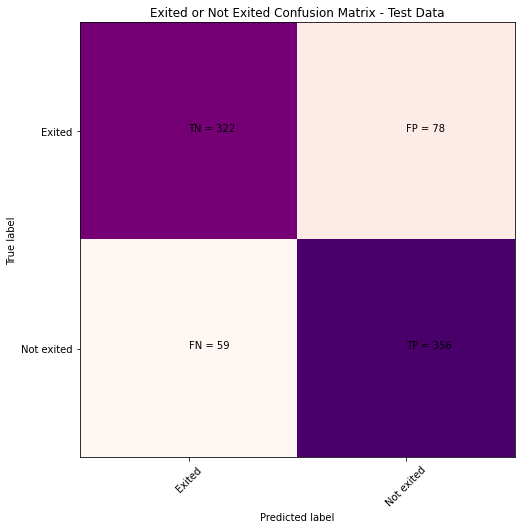

<Figure size 432x288 with 0 Axes>

In [30]:
# Plot the confusion matrix
plt.figure(figsize = (12,8))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu) #plt.cm.Wistia
classNames = ['Exited','Not exited']
plt.title('Exited or Not Exited Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45,)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

plt.savefig(r'C:\Users\Ingrid\Desktop\DAFT Nov 21\Projects\Final project\Confusion_Matrix.png')


Comment: The confusion matrix tells us we a have total of 137 (59 + 78) misclassified data out of the 815 test points (in terms of: exited or not). Most of the values are well predicted.

In [32]:
# Print accuracy of model

# Coefficient between initial and predicted
print('Accuracy: ', (metrics.accuracy_score(x_test["y_initial"],x_test["y_pred"]))*100)

Accuracy:  83.19018404907975


In [38]:
# Print precision value of model
print('Precision value of model: ' , metrics.precision_score(x_test["y_initial"],x_test["y_pred"])) 

Precision value of model:  0.8202764976958525


In [39]:
# Print recall value of model
print('Recall: ', metrics.recall_score(x_test["y_initial"],x_test["y_pred"]))

Recall:  0.8578313253012049


In [37]:
# Print F1 value of model

print('F1: ' , metrics.f1_score(x_test["y_initial"],x_test["y_pred"]))

F1:  0.8386336866902238


Comment: Due to its definition, the F1 score is bounded between 0 and 1, with 1 being perfect precision and recall, and 0 being the worst. 0.8 is pretty good

ROC AUC(Receiver Operating Characteristic Curve) from prediction scores.

In [39]:
# Print ROC AUC score
print('ROC AUC score: ', metrics.roc_auc_score(x_test["y_initial"],x_test["y_pred"]))


ROC AUC score:  0.8331174698795181


<Figure size 864x576 with 0 Axes>

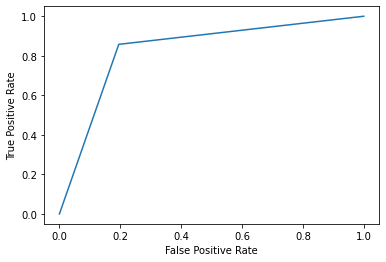

<Figure size 432x288 with 0 Axes>

In [42]:
#Correlation between true positive and false positive rate

fpr, tpr, thresholds = metrics.roc_curve(x_test["y_initial"],x_test["y_pred"])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr) # unique function to plot this relation
display.plot()
plt.show()

plt.savefig(r'C:\Users\Ingrid\Desktop\DAFT Nov 21\Projects\Final project\Correlation_TP_FP.png')

Comment: It's closer to 1, the model recognize more and less the 2 classes and every prediction it makes looks correct.